In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/df_final (1).csv")
df.head()

,merged_text,score,category_cross_encoder,facebook_bart_classification,roberta_classification,final_category
0,I am soooo glad I'm not circumcised! My corona...,2.0,adult,adult,pun,adult
1,Did you know Google now has a platform for rec...,9.0,adult,pun,pun,pun
2,What is the difference between my wife and my ...,15.0,dark humor,pun,adult,dark humor
3,What did the French man say to the attractive ...,2.0,pun,pun,pun,pun
4,"Yo Mama Yo momma's so fat, that when she went ...",0.0,adult,pun,pun,pun


**EDA**

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords

<ipython-input-6-cd62d2acc4ba>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='final_category', order=df['final_category'].value_counts().index, palette="viridis")


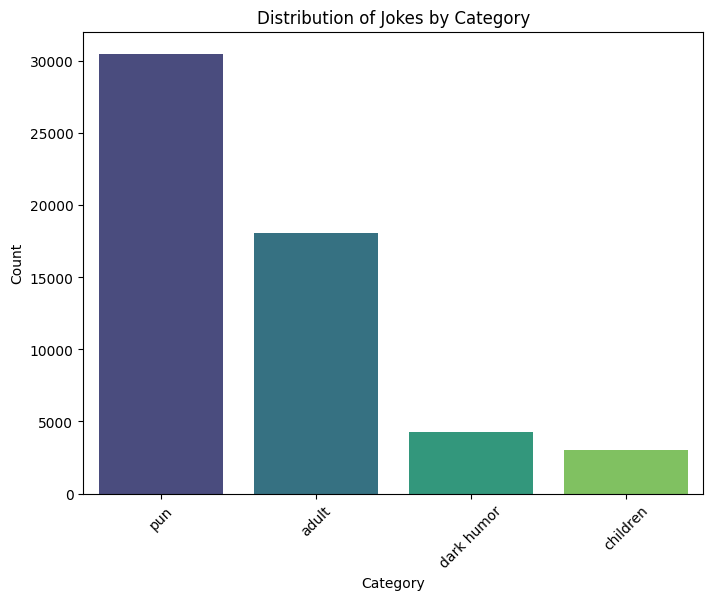

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='final_category', order=df['final_category'].value_counts().index, palette="viridis")
plt.title("Distribution of Jokes by Category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


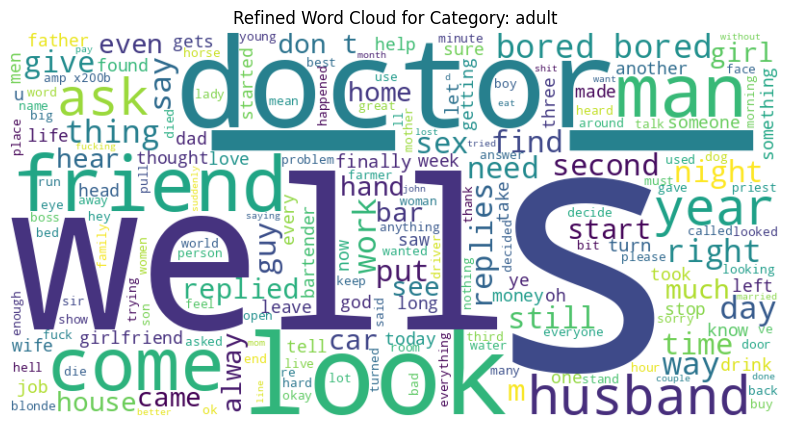

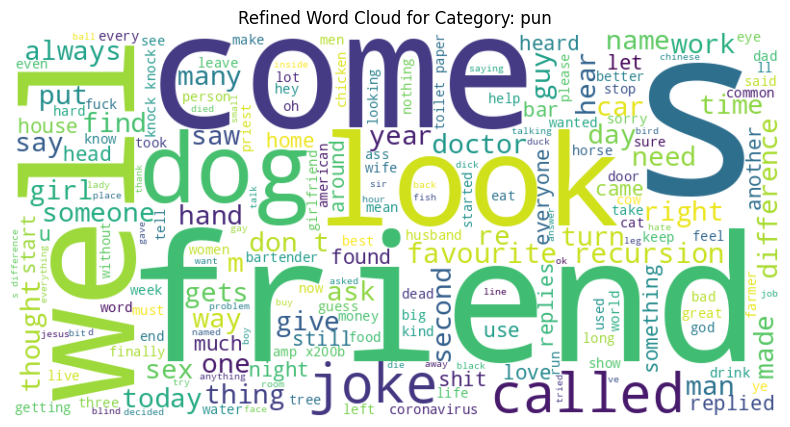

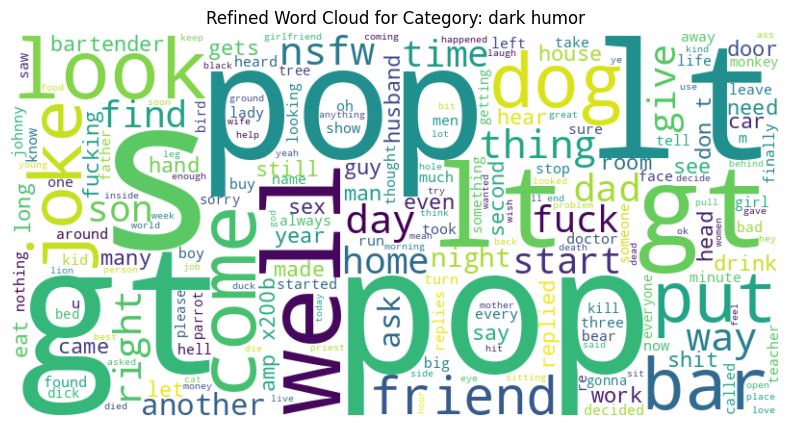

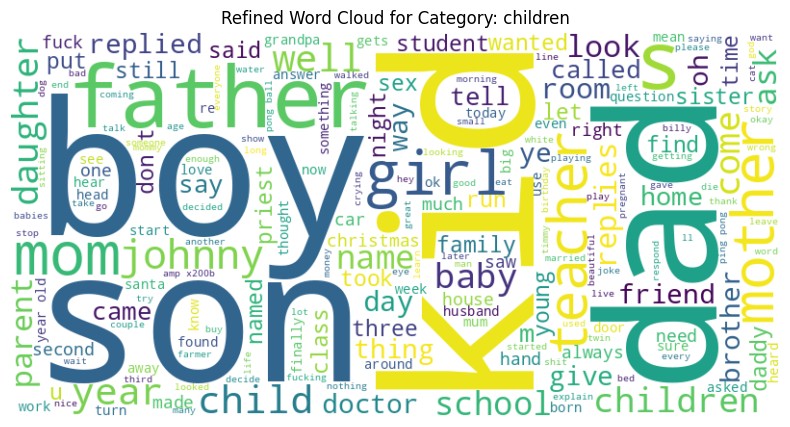

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

all_words = " ".join(df['merged_text']).lower().split()
filtered_all_words = [word for word in all_words if word not in stop_words]
common_words = [word for word, count in Counter(filtered_all_words).most_common(50)]

custom_stop_words = stop_words.union(set(common_words))

for category in df['final_category'].unique():
    jokes = " ".join(df[df['final_category'] == category]['merged_text']).lower()
    filtered_jokes = " ".join([word for word in jokes.split() if word not in custom_stop_words])

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_jokes)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Refined Word Cloud for Category: {category}")
    plt.axis('off')
    plt.show()

<ipython-input-8-5ba824dfbba1>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_length.index, y=avg_length.values, palette="coolwarm")


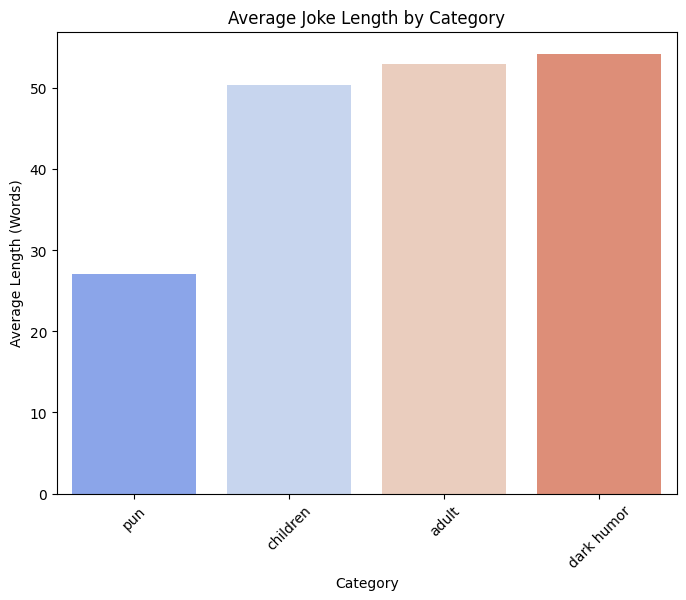

In [ ]:
df['joke_length'] = df['merged_text'].apply(lambda x: len(x.split()))
avg_length = df.groupby('final_category')['joke_length'].mean().sort_values()
plt.figure(figsize=(8, 6))
sns.barplot(x=avg_length.index, y=avg_length.values, palette="coolwarm")
plt.title("Average Joke Length by Category")
plt.xlabel("Category")
plt.ylabel("Average Length (Words)")
plt.xticks(rotation=45)
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-10-0733057e08a5>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette="mako")


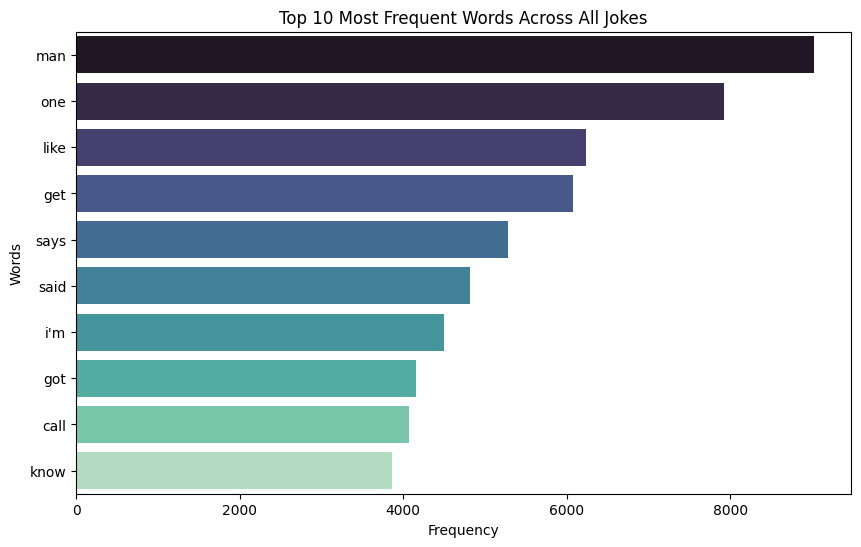

In [ ]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
all_words = " ".join(df['merged_text']).lower().split()
filtered_words = [word for word in all_words if word not in stop_words]
top_words = Counter(filtered_words).most_common(10)

words, counts = zip(*top_words)
plt.figure(figsize=(10, 6))
sns.barplot(x=counts, y=words, palette="mako")
plt.title("Top 10 Most Frequent Words Across All Jokes")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

PREPROCESSING AND MODEL TRAINING

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf.fit_transform(df['merged_text'])

In [6]:
df['final_category_num'] = df['final_category'].map({
    "pun" : 0,
    "children" : 1,
    "adult" : 2,
    "dark humor" : 3
})

In [7]:
df.value_counts('final_category_num')

,count
final_category_num,
0,30518
2,18086
3,4284
1,3051


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['final_category_num'], test_size=0.2, random_state=42)

# Applying SMOTE to training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Class distribution before SMOTE:", pd.Series(y_train).value_counts())
print("Class distribution after SMOTE:", pd.Series(y_train_smote).value_counts())


Class distribution before SMOTE: final_category_num
0    24342
2    14550
3     3437
1     2422
Name: count, dtype: int64
Class distribution after SMOTE: final_category_num
0    24342
2    24342
1    24342
3    24342
Name: count, dtype: int64


In [17]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.72      0.71      6104
           1       0.45      0.34      0.38       610
           2       0.53      0.60      0.56      3617
           3       0.27      0.12      0.17       857

    accuracy                           0.61     11188
   macro avg       0.49      0.44      0.45     11188
weighted avg       0.60      0.61      0.60     11188



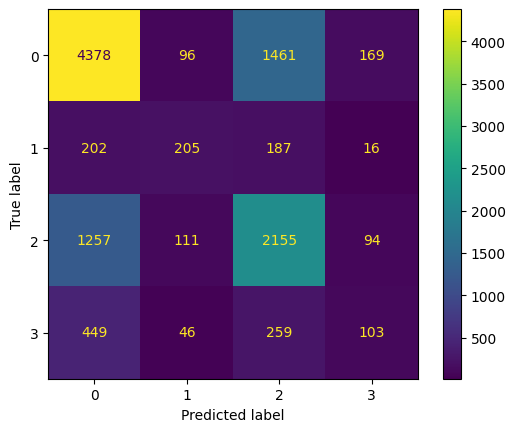

In [14]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix,
    display_labels=[0, 1, 2, 3]  # Changed to include all classes
)

cm_display.plot()
plt.show()

In [15]:
#  preprocess
import spacy
nlp = spacy.load("en_core_web_sm")

def preprocess(text):
  doc = nlp(text)
  filtered_tokens = []
  for token in doc:
    if token.is_stop or token.is_punct:
      continue
    filtered_tokens.append(token.lemma_)

  return " ".join(filtered_tokens)

In [22]:
df['preprocessed_text'] = df.merged_text.apply(preprocess)
df

,merged_text,score,category_cross_encoder,facebook_bart_classification,roberta_classification,final_category,final_category_num,tokens,preprocessed_text
0,I am soooo glad I'm not circumcised! My corona...,2.0,adult,adult,pun,adult,2,"[I, am, soooo, glad, I'm, not, circumcised!, M...",soooo glad circumcise corona cover foreskin ex...
1,Did you know Google now has a platform for rec...,9.0,adult,pun,pun,pun,0,"[Did, you, know, Google, now, has, a, platform...",know Google platform record bowel movement cal...
2,What is the difference between my wife and my ...,15.0,dark humor,pun,adult,dark humor,3,"[What, is, the, difference, between, my, wife,...",difference wife vacuum vacuum snore sex \n\n a...
3,What did the French man say to the attractive ...,2.0,pun,pun,pun,pun,0,"[What, did, the, French, man, say, to, the, at...",french man attractive teletubby Oo lala
4,"Yo Mama Yo momma's so fat, that when she went ...",0.0,adult,pun,pun,pun,0,"[Yo, Mama, Yo, momma's, so, fat,, that, when, ...",Yo Mama Yo momma fat go zoo hippos get jealous
...,...,...,...,...,...,...,...,...,...
55934,"This time, Jessica decided to take Bill out fo...",0.0,adult,pun,adult,adult,2,"[This, time,, Jessica, decided, to, take, Bill...",time Jessica decide Bill dinner night bill
55935,I have a bad habit of looking for right-angles...,2.0,adult,adult,pun,adult,2,"[I, have, a, bad, habit, of, looking, for, rig...",bad habit look right angle normal
55936,"Today at the bank, an old lady asked me to che...",16.0,adult,pun,pun,pun,0,"[Today, at, the, bank,, an, old, lady, asked, ...",today bank old lady ask check balance push
55937,I have been to r/fallout . It not as toxic as ...,1.0,adult,pun,pun,pun,0,"[I, have, been, to, r/fallout, ., It, not, as,...",r fallout toxic tell radioactive


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf.fit_transform(df['preprocessed_text'])

In [9]:
df.to_csv('/content/df_preprocessed.csv', index=False)

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['final_category_num'], test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Class distribution before SMOTE:", pd.Series(y_train).value_counts())
print("Class distribution after SMOTE:", pd.Series(y_train_smote).value_counts())

Class distribution before SMOTE: final_category_num
0    24342
2    14550
3     3437
1     2422
Name: count, dtype: int64
Class distribution after SMOTE: final_category_num
0    24342
2    24342
1    24342
3    24342
Name: count, dtype: int64


In [18]:
# Model training
model = RandomForestClassifier()
model.fit(X_train_smote, y_train_smote)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.76      0.73      6176
           1       0.62      0.74      0.67       629
           2       0.56      0.56      0.56      3536
           3       0.44      0.16      0.23       847

    accuracy                           0.65     11188
   macro avg       0.58      0.55      0.55     11188
weighted avg       0.64      0.65      0.64     11188



In [19]:
import pickle

# Savinng the model to a file
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)
print("Model saved as clf_model.pkl")


Model saved as clf_model.pkl


In [21]:
import pickle

# Loading the pickled model
model_path = "/content/model.pkl"
with open(model_path, 'rb') as file:
    model = pickle.load(file)

print("Model loaded successfully!")

Model loaded successfully!


In [25]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.76      0.73      6176
           1       0.62      0.74      0.67       629
           2       0.56      0.56      0.56      3536
           3       0.44      0.16      0.23       847

    accuracy                           0.65     11188
   macro avg       0.58      0.55      0.55     11188
weighted avg       0.64      0.65      0.64     11188



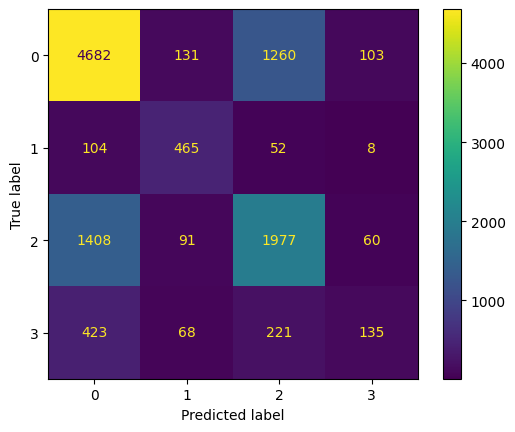

In [26]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix,
    display_labels=[0, 1, 2, 3]
)

cm_display.plot()
plt.show()